# Bed simulation

In [159]:
"""
Bed counter-factual Simulation

Covers:

- Resources: Resource
- Resources: Container
- Waiting for other processes

Scenario:
    We are trying to assess if using a non-greedy approach would
     reduce the number of patients boarded to the wrong ward

- A patient arrives at the beds_correct - the logic!
beds = simulated_beds + remaining_beds

# If there are no beds in the correct specialty area irl
if remaining_beds=0:
    boarded = True
else:
    boarded = False
# If there are no beds in the simulation for the correct specialty area
if beds <= 0 | predicted_board:
    simulation_boarded = True
else:
    simulation_boarded = False

if simulation_boarded & boarded:
    wait for a bit
    leave
if simulation_boarded & not boarded:
    increment simulated beds
    wait for a bit
    leave
if not simulation_boarded & boarded:
    decrement simulation beds
    wait for a bit
if not simulation_boarded & not boarded:  # repeated for readability...
    wait for a bit
    leave
"""
import itertools
import random
import pandas as pd
import numpy as np
import simpy


RANDOM_SEED = 42
T_INTER = [5, 20]        # Create a patient every [min, max] minutes
SIM_TIME = 60*12*30          # Simulation time in minutes
NUMBER_OF_BEDS = 200

df = pd.read_csv('data.csv')
df['counter_mort'] = np.random.uniform(low=0, high=1, size=(df.shape[0],))
#df['counter_mort'] = np.random.lognormal(mean=0.3, sigma=1)
#df['counter_mort'] = df['counter_mort'].apply(lambda x: (1 if x > 1 else x))
df['predicted_boarded'] = df['counter_mort'].apply(lambda x: x > 0.5)
df['mort'] = df['days_survived'].apply(lambda x: x <= 30)
patients = df.to_dict(orient='records')

# Toy data
#patients = [{'transfers.subject_id': 1, 'icustay_los_total': 50, 'remaining_beds': 6, 'predicted_boarded': False},
#            {'transfers.subject_id': 2, 'icustay_los_total': 30, 'remaining_beds': 6, 'predicted_boarded': False}]


global simulated_beds
simulated_beds = 0
mortalityStore = []
agreementStore = []


def patient(env, beds_correct, **p):
    global simulated_beds
    print('%s arriving at ICU at %.1f' % (p['transfers.subject_id'], env.now))
    
    beds = simulated_beds + p['remaining_beds']
    print("beds",beds, simulated_beds)
    if p['icustay_boarder_initial'] == 1:
        boarded = True
    else:
        boarded = False

    # If there are no beds in the simulation for the correct specialty area
    if p['predicted_boarded']:
        simulation_boarded = True
    else:
        simulation_boarded = False
        print("Became false!", p['predicted_boarded'], beds)

    if simulation_boarded & boarded:
        print("Agreed boarding")
        agreementStore.append("Agreed boarding")
        mortalityStore.append(p['mort'])
        with beds_correct.request() as req:
            start = env.now
            # Request one of the beds
            yield req
            # Stay in a bed for a bit
            yield env.timeout(p['icustay_los_total'])
            print('%s left ward in %.1f minutes.' % (p['transfers.subject_id'], env.now - start))

    elif simulation_boarded & (not boarded):
        print("Disagree boarding")
        agreementStore.append("Disagree boarding")
        mortalityStore.append(p['counter_mort'])
        with beds_correct.request() as req:
            start = env.now
            simulated_beds += 1
            # Request one of the beds
            yield req
            # Stay in a bed for a bit
            yield env.timeout(p['icustay_los_total'])
            #simulated_beds -= 1
            print('%s left ward in %.1f minutes.' % (p['transfers.subject_id'], env.now - start))

    elif (not simulation_boarded) and boarded:
        print(beds)
        if beds > 0:
            print("Disagree not boarding, boarding")
            agreementStore.append("Disagree not boarding")
            mortalityStore.append(p['counter_mort'])
            with beds_correct.request() as req:
                start = env.now
                simulated_beds -= 1
                # Request one of the beds
                yield req
                # Stay in a bed for a bit
                yield env.timeout(p['icustay_los_total'])
                simulated_beds += 1
                print('%s left ward in %.1f minutes.' % (p['transfers.subject_id'], env.now - start))
        else:
            print("Not enough beds")
            agreementStore.append("Agreed boarding")
            mortalityStore.append(p['mort'])
            with beds_correct.request() as req:
                start = env.now
                # Request one of the beds
                yield req
                # Stay in a bed for a bit
                yield env.timeout(p['icustay_los_total'])
                print('%s left ward in %.1f minutes.' % (p['transfers.subject_id'], env.now - start))

            
    elif (not simulation_boarded) and (not boarded):
        if beds > 0:
            print("Agreed not boarding")
            agreementStore.append("Agreed not boarding")
            mortalityStore.append(p['mort'])
            with beds_correct.request() as req:
                start = env.now
                # Request one of the beds
                yield req
                # Stay in a bed for a bit
                yield env.timeout(p['icustay_los_total'])
                print('%s left ward in %.1f minutes.' % (p['transfers.subject_id'], env.now - start))
        else:
            print("Not enough beds, boarding")
            agreementStore.append("Agreed boarding")
            mortalityStore.append(p['mort'])
            with beds_correct.request() as req:
                start = env.now
                # Request one of the beds
                yield req
                # Stay in a bed for a bit
                yield env.timeout(p['icustay_los_total'])
                print('%s left ward in %.1f minutes.' % (p['transfers.subject_id'], env.now - start))




def patient_generator(env, beds_correct, patients):
    """Generate new patient that arrive at the ICU."""
    for i in itertools.count():
        yield env.timeout(random.randint(*T_INTER))
        p = random.sample(patients, 1)[0]
        #print_name = 'Simulation id {}'.format(i) #, Data id  %s' % (i, p['transfers.subject_id'])
        env.process(patient(env, beds_correct, **p))


# Create environment and start processes
env = simpy.Environment()
beds_correct = simpy.Resource(env, NUMBER_OF_BEDS)
#bed_boarded = simpy.Resource(env, 1, NUMBER_OF_BEDS)
env.process(patient_generator(env, beds_correct, patients)) #beds_boarded,

# Execute!
env.run(until=SIM_TIME)

print(simulated_beds)




/Users/andrevauvelle/anaconda3/envs/flask/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2548 arriving at ICU at 14.0
beds 8 0
Became false! False 8
Agreed not boarding
29650 arriving at ICU at 19.0
beds 2 0
Disagree boarding
29650 left ward in 0.4 minutes.
8972 arriving at ICU at 30.0
beds 5 1
Became false! False 5
5
Disagree not boarding, boarding
25837 arriving at ICU at 48.0
beds 1 0
Became false! False 1
1
Disagree not boarding, boarding
8972 left ward in 22.2 minutes.
2548 left ward in 43.0 minutes.
83937 arriving at ICU at 66.0
beds 4 0
Disagree boarding
42555 arriving at ICU at 81.0
beds 3 1
Became false! False 3
Agreed not boarding
24682 arriving at ICU at 86.0
beds 4 1
Became false! False 4
Agreed not boarding
42555 left ward in 19.7 minutes.
51791 arriving at ICU at 106.0
beds 2 1
Became false! False 2
Agreed not boarding
25837 left ward in 65.1 minutes.
46961 arriving at ICU at 121.0
beds 10 2
Became false! False 10
Agreed not boarding
51791 left ward in 21.7 minutes.
19385 arriving at ICU at 130.0
beds 4 2
Became false! False 4
Agreed not boarding
46961 left w

14411 arriving at ICU at 2893.0
beds 90 85
Disagree boarding
31369 arriving at ICU at 2900.0
beds 90 86
Disagree boarding
55673 arriving at ICU at 2913.0
beds 94 87
Disagree boarding
18975 arriving at ICU at 2931.0
beds 89 88
Agreed boarding
19126 arriving at ICU at 2941.0
beds 90 88
Agreed boarding
14411 left ward in 49.4 minutes.
55673 left ward in 36.7 minutes.
31369 left ward in 50.1 minutes.
94229 left ward in 118.8 minutes.
14766 arriving at ICU at 2957.0
beds 90 88
Became false! False 90
Agreed not boarding
23249 left ward in 93.1 minutes.
74376 arriving at ICU at 2966.0
beds 89 88
Disagree boarding
14766 left ward in 19.4 minutes.
82188 arriving at ICU at 2982.0
beds 93 89
Disagree boarding
78705 left ward in 127.7 minutes.
77948 arriving at ICU at 2991.0
beds 93 90
Became false! False 93
Agreed not boarding
16640 left ward in 116.9 minutes.
82188 left ward in 24.4 minutes.
65759 arriving at ICU at 3007.0
beds 91 90
Became false! False 91
Agreed not boarding
74376 left ward in 

beds 155 154
Agreed boarding
86323 arriving at ICU at 5143.0
beds 156 154
Became false! False 156
Agreed not boarding
9908 arriving at ICU at 5160.0
beds 158 154
Disagree boarding
49872 left ward in 60.8 minutes.
12166 left ward in 147.7 minutes.
41547 left ward in 87.8 minutes.
9195 arriving at ICU at 5180.0
beds 159 155
Disagree boarding
16864 arriving at ICU at 5195.0
beds 159 156
Became false! False 159
Agreed not boarding
9908 left ward in 35.7 minutes.
5957 left ward in 72.0 minutes.
70077 arriving at ICU at 5210.0
beds 160 156
Became false! False 160
Agreed not boarding
16864 left ward in 18.8 minutes.
32247 left ward in 103.8 minutes.
31307 arriving at ICU at 5230.0
beds 159 156
Became false! False 159
Agreed not boarding
1893 left ward in 182.0 minutes.
70077 left ward in 24.9 minutes.
51203 arriving at ICU at 5246.0
beds 165 156
Agreed boarding
9195 left ward in 71.6 minutes.
66015 arriving at ICU at 5266.0
beds 158 156
Became false! False 158
Agreed not boarding
31307 left w

Became false! False 234
Agreed not boarding
50391 left ward in 46.9 minutes.
26236 arriving at ICU at 7540.0
beds 237 232
Disagree boarding
40435 arriving at ICU at 7548.0
beds 236 233
Became false! False 236
Agreed not boarding
42492 left ward in 104.9 minutes.
21769 arriving at ICU at 7563.0
beds 235 233
Became false! False 235
Agreed not boarding
26236 left ward in 29.2 minutes.
40435 left ward in 26.0 minutes.
25338 arriving at ICU at 7576.0
beds 235 233
Became false! False 235
Agreed not boarding
49858 arriving at ICU at 7594.0
beds 235 233
Disagree boarding
46105 arriving at ICU at 7604.0
beds 237 234
Became false! False 237
Agreed not boarding
49858 left ward in 18.0 minutes.
62506 arriving at ICU at 7619.0
beds 235 234
Disagree boarding
7336 arriving at ICU at 7632.0
beds 238 235
Became false! False 238
Agreed not boarding
84165 arriving at ICU at 7637.0
beds 238 235
Became false! False 238
Agreed not boarding
31692 arriving at ICU at 7653.0
beds 236 235
Agreed boarding
25338 l

9300 arriving at ICU at 10061.0
beds 312 309
Disagree boarding
86144 left ward in 223.5 minutes.
32217 arriving at ICU at 10079.0
beds 311 310
Disagree boarding
9300 left ward in 23.9 minutes.
31838 left ward in 69.7 minutes.
19183 left ward in 112.6 minutes.
61971 arriving at ICU at 10097.0
beds 314 312
Became false! False 314
Agreed not boarding
32217 left ward in 20.4 minutes.
13406 arriving at ICU at 10114.0
beds 315 312
Disagree boarding
56108 left ward in 74.3 minutes.
19685 arriving at ICU at 10132.0
beds 313 313
Agreed boarding
41875 arriving at ICU at 10140.0
beds 316 313
Disagree boarding
13406 left ward in 28.7 minutes.
61971 left ward in 51.1 minutes.
49053 arriving at ICU at 10158.0
beds 316 314
Disagree boarding
17328 arriving at ICU at 10173.0
beds 317 315
Became false! False 317
317
Disagree not boarding, boarding
49053 left ward in 17.7 minutes.
54592 arriving at ICU at 10187.0
beds 317 314
Became false! False 317
Agreed not boarding
9914 arriving at ICU at 10197.0
bed

Became false! False 367
Agreed not boarding
1492 left ward in 22.4 minutes.
26930 left ward in 336.2 minutes.
51628 arriving at ICU at 11862.0
beds 366 364
Became false! False 366
Agreed not boarding
16882 arriving at ICU at 11880.0
beds 365 364
Agreed boarding
54479 left ward in 74.8 minutes.
92244 arriving at ICU at 11890.0
beds 367 364
Became false! False 367
Agreed not boarding
4120 arriving at ICU at 11901.0
beds 364 364
Agreed boarding
40253 arriving at ICU at 11910.0
beds 365 364
Disagree boarding
51628 left ward in 50.5 minutes.
16882 left ward in 36.4 minutes.
32293 arriving at ICU at 11921.0
beds 366 365
Became false! False 366
Agreed not boarding
4120 left ward in 27.4 minutes.
25886 arriving at ICU at 11934.0
beds 367 365
Became false! False 367
Agreed not boarding
20936 arriving at ICU at 11951.0
beds 366 365
Disagree boarding
92244 left ward in 62.3 minutes.
97714 arriving at ICU at 11958.0
beds 368 366
Disagree boarding
75782 left ward in 116.6 minutes.
32293 left ward i

beds 425 424
Became false! False 425
Agreed not boarding
64846 arriving at ICU at 13746.0
beds 424 424
Agreed boarding
8445 left ward in 67.6 minutes.
23475 arriving at ICU at 13761.0
beds 427 424
Disagree boarding
7487 left ward in 32.2 minutes.
76143 arriving at ICU at 13769.0
beds 427 425
Became false! False 427
Agreed not boarding
65630 left ward in 95.3 minutes.
29631 left ward in 118.2 minutes.
23475 left ward in 20.3 minutes.
17278 arriving at ICU at 13787.0
beds 426 425
Became false! False 426
Agreed not boarding
16807 arriving at ICU at 13798.0
beds 426 425
Disagree boarding
20485 arriving at ICU at 13805.0
beds 431 426
Became false! False 431
Agreed not boarding
738 left ward in 84.4 minutes.
76143 left ward in 39.8 minutes.
64846 left ward in 63.9 minutes.
16807 left ward in 16.1 minutes.
65956 arriving at ICU at 13821.0
beds 430 427
Disagree boarding
88081 left ward in 313.4 minutes.
20485 left ward in 24.5 minutes.
71942 arriving at ICU at 13837.0
beds 431 428
Disagree boa

22548 arriving at ICU at 15125.0
beds 465 463
Disagree boarding
81245 left ward in 64.9 minutes.
76676 arriving at ICU at 15131.0
beds 472 464
Became false! False 472
Agreed not boarding
21362 left ward in 121.0 minutes.
7440 arriving at ICU at 15138.0
beds 465 464
Became false! False 465
Agreed not boarding
77081 left ward in 31.9 minutes.
1905 left ward in 41.0 minutes.
76676 left ward in 21.8 minutes.
24338 left ward in 69.5 minutes.
50928 arriving at ICU at 15156.0
beds 466 465
Disagree boarding
27379 arriving at ICU at 15161.0
beds 469 466
Disagree boarding
21160 arriving at ICU at 15171.0
beds 468 467
Disagree boarding
7440 left ward in 37.5 minutes.
11838 arriving at ICU at 15180.0
beds 469 468
Became false! False 469
Agreed not boarding
54589 arriving at ICU at 15190.0
beds 478 468
Disagree boarding
54589 left ward in 17.0 minutes.
22835 arriving at ICU at 15209.0
beds 471 469
Disagree boarding
18529 left ward in 238.6 minutes.
22548 left ward in 91.3 minutes.
24276 arriving at

beds 513 510
Became false! False 513
Agreed not boarding
17260 left ward in 65.1 minutes.
5996 arriving at ICU at 16783.0
beds 515 510
Disagree boarding
12274 left ward in 35.0 minutes.
30260 left ward in 327.3 minutes.
12450 left ward in 61.9 minutes.
24847 arriving at ICU at 16803.0
beds 516 514
Became false! False 516
Agreed not boarding
18753 arriving at ICU at 16808.0
beds 515 514
Disagree boarding
22289 arriving at ICU at 16823.0
beds 516 515
Became false! False 516
Agreed not boarding
95036 arriving at ICU at 16831.0
beds 516 515
Disagree boarding
31584 arriving at ICU at 16838.0
beds 517 516
Became false! False 517
517
Disagree not boarding, boarding
95036 left ward in 18.7 minutes.
41935 arriving at ICU at 16851.0
beds 515 515
Became false! False 515
515
Disagree not boarding, boarding
78388 left ward in 93.7 minutes.
18753 left ward in 49.5 minutes.
11202 arriving at ICU at 16861.0
beds 523 514
Became false! False 523
Agreed not boarding
24847 left ward in 58.7 minutes.
11202

Agreed not boarding
3145 arriving at ICU at 18365.0
beds 568 566
Disagree boarding
81560 arriving at ICU at 18378.0
beds 567 567
Agreed boarding
60659 arriving at ICU at 18391.0
beds 572 567
Became false! False 572
Agreed not boarding
97143 left ward in 43.4 minutes.
67443 arriving at ICU at 18403.0
beds 569 567
Became false! False 569
Agreed not boarding
79224 arriving at ICU at 18408.0
beds 570 567
Disagree boarding
52455 arriving at ICU at 18417.0
beds 569 568
Became false! False 569
Agreed not boarding
67443 left ward in 17.5 minutes.
81560 left ward in 44.1 minutes.
51859 arriving at ICU at 18427.0
beds 572 568
Became false! False 572
Agreed not boarding
52455 left ward in 11.3 minutes.
30288 arriving at ICU at 18432.0
beds 572 568
Disagree boarding
30288 left ward in 5.9 minutes.
63761 arriving at ICU at 18443.0
beds 572 569
Became false! False 572
Agreed not boarding
17145 left ward in 119.8 minutes.
3145 left ward in 92.9 minutes.
6027 arriving at ICU at 18461.0
beds 573 569
Di

48794 arriving at ICU at 20228.0
beds 619 618
Became false! False 619
Agreed not boarding
7427 left ward in 46.4 minutes.
75864 arriving at ICU at 20241.0
beds 619 618
Disagree boarding
48794 left ward in 22.2 minutes.
516 arriving at ICU at 20251.0
beds 624 619
Became false! False 624
Agreed not boarding
27729 left ward in 311.2 minutes.
516 left ward in 4.8 minutes.
89085 arriving at ICU at 20256.0
beds 622 619
Disagree boarding
31300 arriving at ICU at 20266.0
beds 620 620
Agreed boarding
5367 left ward in 309.5 minutes.
4812 arriving at ICU at 20275.0
beds 621 620
Disagree boarding
89085 left ward in 34.0 minutes.
21939 arriving at ICU at 20294.0
beds 622 621
Agreed boarding
21939 left ward in 1.3 minutes.
21185 left ward in 266.7 minutes.
42460 arriving at ICU at 20308.0
beds 625 621
Disagree boarding
81737 arriving at ICU at 20313.0
beds 623 622
Became false! False 623
Agreed not boarding
75864 left ward in 77.3 minutes.
43543 arriving at ICU at 20320.0
beds 628 622
Became false!

In [160]:
%matplotlib notebook
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


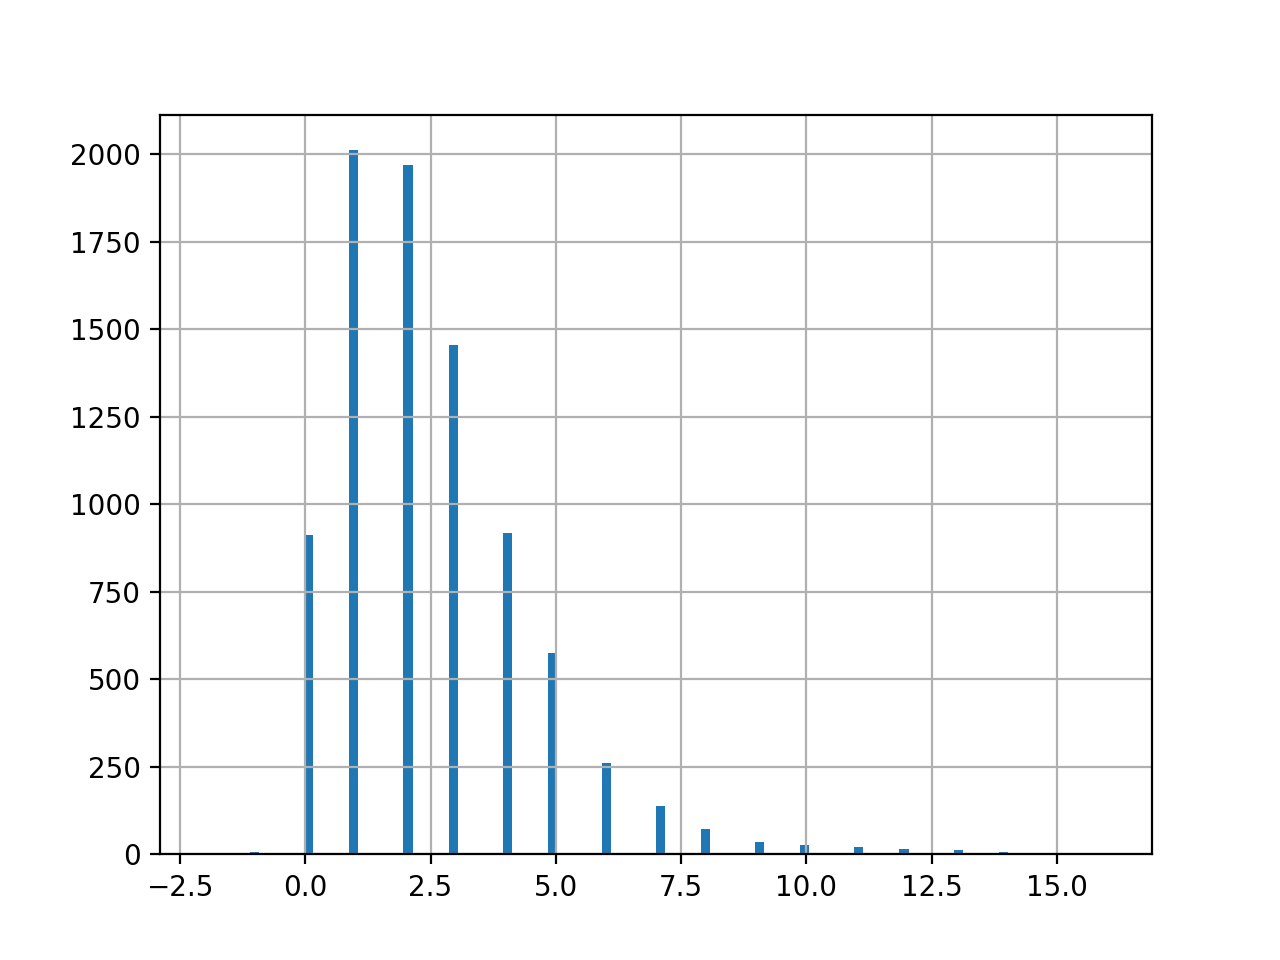

In [161]:
df['remaining_beds'].hist(bins = 100)

In [162]:
pd.Series(agreementStore).value_counts()

Disagree boarding        675
Agreed not boarding      659
Disagree not boarding    208
Agreed boarding          183
dtype: int64

<IPython.core.display.Javascript object>


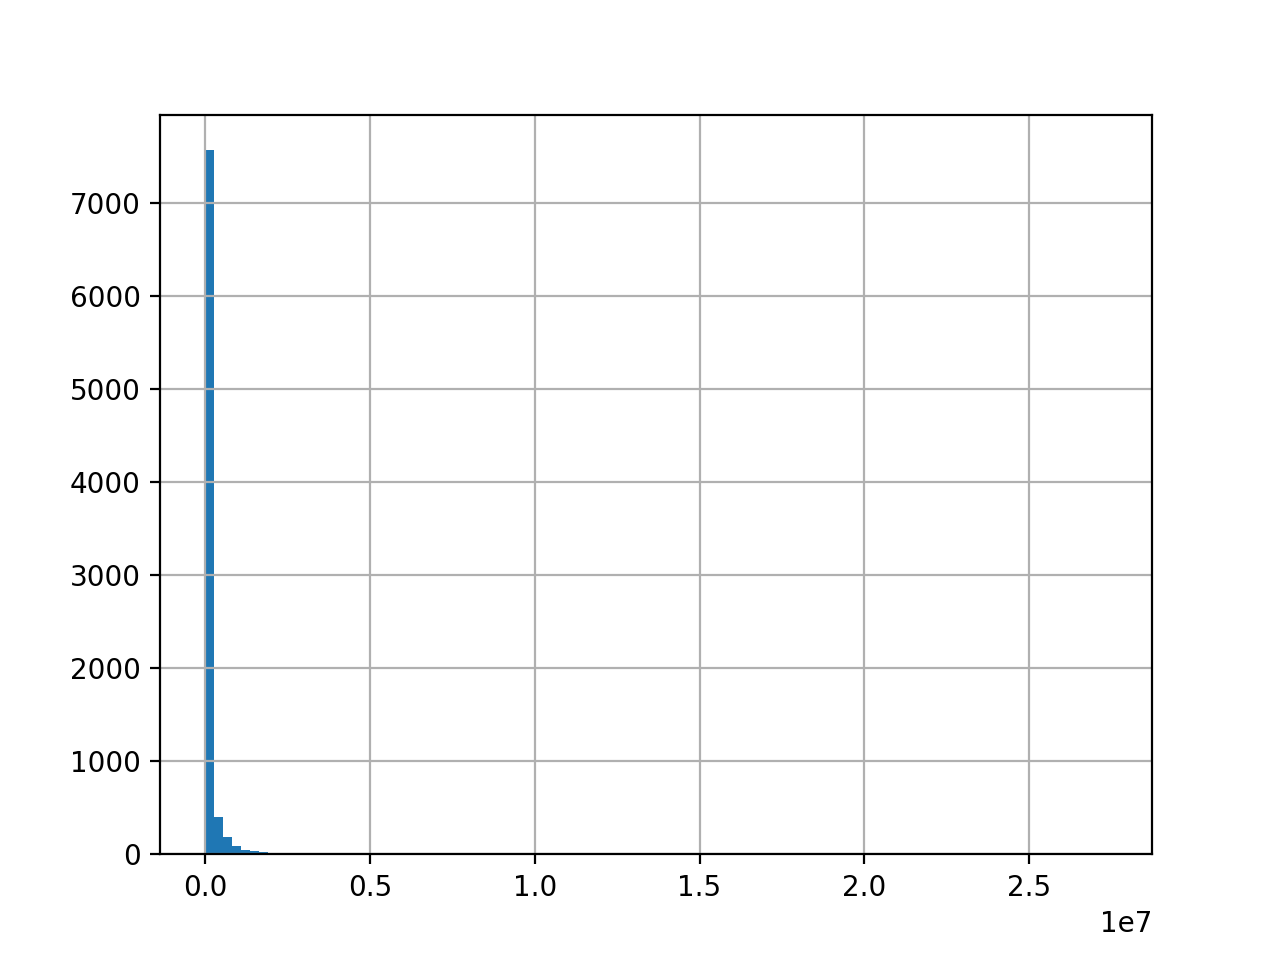

In [169]:
plt.figure()
df['counter_mort'] = np.random.lognormal(mean=1, sigma=2, size=(df.shape[0],))
df['counter_mort'] = df['counter_mort'].apply(lambda x: (1 if x > 1 else x))
df['counter_mort'].hist(bins=100)

In [144]:
df.columns

Index(['transfers.subject_id', 'transfers.hadm_id', 'transfers.icustay_id',
       'transfers.eventtype', 'team_census', 'blocked_count', 'remaining_beds',
       'icustay_los_total', 'icustay_los_boarder', 'icustay_boarder_initial',
       ...
       'sofa_cardiovascular', 'sofa_cns', 'sofa_renal', 'days_survived_dt',
       'days_survived_dt2', 'time_diff',
       'icustay_outtime_deathtime_difference', 'counter_mort',
       'predicted_boarded', 'mort'],
      dtype='object', length=135)